In [1]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from shap.datasets import adult
from ensemble import utils, Ensemble
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Load data
X, Y = adult()
X = X.values
Y = Y.astype(int)
print(f'X.shape = {X.shape}, Y.shape = {Y.shape}')

# Split into training, val, test
val_portion = 0.2
test_portion = 0.2

# Shuffle inds
np.random.seed(0)
inds = np.arange(len(X))
np.random.shuffle(inds)
num_val = int(len(X) * val_portion)
num_test = int(len(X) * test_portion)

# Apply split
X_val, Y_val = X[:num_val], Y[:num_val]
X_test, Y_test = X[num_val:num_val+num_test], Y[num_val:num_val+num_test]
X_train, Y_train = X[num_val+num_test:], Y[num_val+num_test:]
del X, Y
print(f'train examples = {len(X_train)}, val examples = {len(X_val)}, test examples = {len(X_test)}')

X.shape = (32561, 12), Y.shape = (32561,)
train examples = 19537, val examples = 6512, test examples = 6512


In [3]:
# Train models
np.random.seed(0)
num_features = 5
num_models = 10
models = []
for seed in range(num_models):
    # Generate feature mask
    inds = np.random.choice(X_train.shape[1], num_features, replace=False)
    mask = np.zeros(X_train.shape[1])
    mask[inds] = 1
    
    # Create sklearn classifiers
    model = GradientBoostingClassifier(n_estimators=200, max_depth=3, random_state=seed)
    model.fit(X_train * mask, Y_train)
    models.append(model)

In [4]:
# Calculate performance metrics for each model
for model in models:
    # Training performance
    preds = model.predict_proba(X_train)
    train_loss = utils.log_loss(preds, Y_train)
    train_acc = utils.accuracy(preds, Y_train)

    # Validation performance
    preds = model.predict_proba(X_val)
    val_loss = utils.log_loss(preds, Y_val)
    val_acc = utils.accuracy(preds, Y_val)
    print(f'Train loss = {train_loss:.2f}, train acc = {100 * train_acc:.2f}, val loss = {val_loss:.2f}, val acc = {100 * val_acc:.2f}')

Train loss = 0.43, train acc = 79.90, val loss = 0.45, val acc = 79.13
Train loss = 0.34, train acc = 84.13, val loss = 0.35, val acc = 82.94
Train loss = 0.42, train acc = 80.59, val loss = 0.45, val acc = 79.58
Train loss = 0.29, train acc = 86.86, val loss = 0.31, val acc = 85.96
Train loss = 0.38, train acc = 80.89, val loss = 0.38, val acc = 80.59
Train loss = 0.30, train acc = 86.32, val loss = 0.32, val acc = 85.47
Train loss = 0.34, train acc = 84.14, val loss = 0.36, val acc = 83.31
Train loss = 0.42, train acc = 80.85, val loss = 0.44, val acc = 79.48
Train loss = 0.41, train acc = 80.49, val loss = 0.42, val acc = 79.58
Train loss = 0.41, train acc = 83.06, val loss = 0.42, val acc = 82.92


In [5]:
# Aggregate validation and test predictions
val_preds = {f'LGBM ({i})': model.predict_proba(X_val) for i, model in enumerate(models)}
test_preds = {f'LGBM ({i})': model.predict_proba(X_test) for i, model in enumerate(models)}

# Evaluate models in isolation
val_loss = {name: utils.log_loss(preds, Y_val) for name, preds in val_preds.items()}
val_acc = {name: utils.accuracy(preds, Y_val) for name, preds in val_preds.items()}
test_loss = {name: utils.log_loss(preds, Y_test) for name, preds in test_preds.items()}
test_acc = {name: utils.accuracy(preds, Y_test) for name, preds in test_preds.items()}

# Try SQP solver

In [11]:
from ensemble import utils
from ensemble.sqp_solvers import solve_multiclass_logloss_probs, solve_multiclass_logloss_logits
from ensemble.sqp_solvers import multiclass_logloss_logits_helper, multiclass_logloss_probs_helper

In [7]:
# Probs version
probs_weights = solve_multiclass_logloss_probs(list(val_preds.values()), Y_val)
probs_weights = solve_multiclass_logloss_probs([preds[:1000] for preds in val_preds.values()], Y_val[:1000])

# # Logits version
logit_preds = [utils.stable_logit(preds) for preds in val_preds.values()]
nonneg_weights = solve_multiclass_logloss_logits(logit_preds, Y_val, 'nonnegative')
simplex_weights = solve_multiclass_logloss_logits(logit_preds, Y_val, 'simplex')

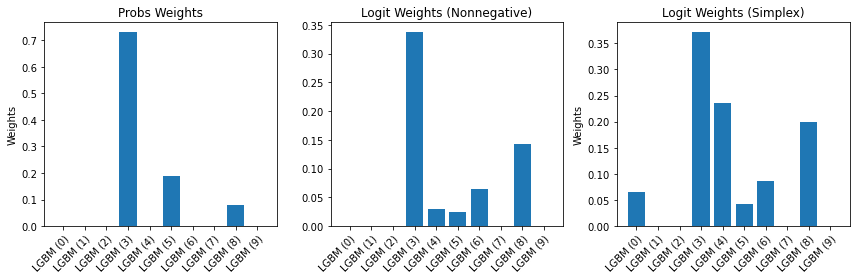

In [8]:
# Plot learned weights
fig, axarr = plt.subplots(1, 3, figsize=(12, 4))

plt.sca(axarr[0])
plt.bar(range(len(models)), probs_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Probs Weights')
plt.ylabel('Weights')

plt.sca(axarr[1])
plt.bar(range(len(models)), nonneg_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Learned Ensemble Weights')
plt.title('Logit Weights (Nonnegative)')

plt.sca(axarr[2])
plt.bar(range(len(models)), simplex_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Logit Weights (Simplex)')
plt.ylabel('Weights')

plt.tight_layout()
plt.show()

# Compare to CVXPY solver

In [9]:
# Get weights from CVXPY solver
ensemble = Ensemble('multi:logloss_probs', 'simplex')
ensemble_probs_weights = ensemble.solver([preds[:1000] for preds in val_preds.values()], Y_val[:1000], 'simplex', verbose=True)

# # Logits version
ensemble = Ensemble('multi:logloss_logits', 'simplex')
ensemble_simplex_weights = ensemble.solver(logit_preds, Y_val, 'simplex', verbose=True)
ensemble_nonneg_weights = ensemble.solver(logit_preds, Y_val, 'nonnegative')

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jul 30 12:13:13 PM: Your problem has 10 variables, 2 constraints, and 0 parameters.
(CVXPY) Jul 30 12:13:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 30 12:13:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 30 12:13:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 30 12:13:13 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 30 12:13:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [12]:
# Consistency between CVXPY and SQP
print(f'CVXPY objective value (probs): {multiclass_logloss_probs_helper(list(val_preds.values()), Y_val, ensemble_probs_weights)[0]}')
print(f'SQP objective value (probs): {multiclass_logloss_probs_helper(list(val_preds.values()), Y_val, probs_weights)[0]}')

# Logits version
print(f'CVXPY objective value (simplex): {multiclass_logloss_logits_helper(logit_preds, Y_val, ensemble_simplex_weights)[0]}')
print(f'CVXPY objective value (nonneg): {multiclass_logloss_logits_helper(logit_preds, Y_val, ensemble_nonneg_weights)[0]}')
print(f'SQP objective value (simplex): {multiclass_logloss_logits_helper(logit_preds, Y_val, simplex_weights)[0]}')
print(f'SQP objective value (nonneg): {multiclass_logloss_logits_helper(logit_preds, Y_val, nonneg_weights)[0]}')

CVXPY objective value (probs): 1972.6110234297776
SQP objective value (probs): 1972.6115284328225
CVXPY objective value (simplex): 2097.906819401247
CVXPY objective value (nonneg): 1918.555604562258
SQP objective value (simplex): 2097.906821043045
SQP objective value (nonneg): 1918.5556090634464


# Confirm CVXPY version with probs still doesn't work

In [13]:
ensemble = Ensemble('multi:logloss_probs', 'simplex')
ensemble.fit(list(val_preds.values()), Y_val)

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

# Try unconstrained solver

In [14]:
unconstrained_weights = solve_multiclass_logloss_logits(logit_preds, Y_val, 'none', verbose=True)

Objective after step 1: 2184.9827028297386
Objective after step 2: 1916.116680028233
Objective after step 3: 1889.5539663762625
Objective after step 4: 1888.5656862057594
Objective after step 5: 1888.563362738729
Objective after step 6: 1888.5633627228988
Stopping after 6 steps


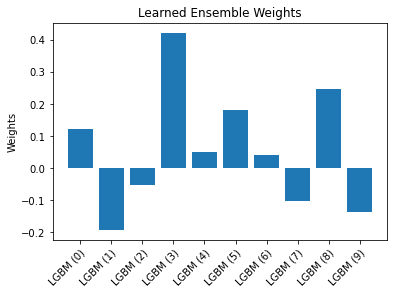

In [15]:
# Plot learned weights
plt.figure()
plt.bar(range(len(models)), unconstrained_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Learned Ensemble Weights')
plt.ylabel('Weights')
plt.show()

In [16]:
print(f'SQP objective value (nonneg): {multiclass_logloss_logits_helper(logit_preds, Y_val, unconstrained_weights)[0]}')

SQP objective value (nonneg): 1888.5633627228988
